## Loading the packages

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import sys

import pandas as pd
from ipywidgets import interact, widgets
import os

%matplotlib inline

In [2]:
PATH = '../vowels'

from python_speech_features import mfcc
import scipy.io.wavfile as wav

import glob
nam_paths = glob.glob(os.path.join(PATH, 'nam*.wav'))
naf_paths = glob.glob(os.path.join(PATH, 'naf*.wav'))
nk_paths = glob.glob(os.path.join(PATH, 'nk*.wav'))

# Imports Dataset

In [3]:
# Here we read the wave files and store their content in lists
naf_audios = [wav.read(path) for path in naf_paths]
nam_audios = [wav.read(path) for path in nam_paths]

# Import medians of the mfcc
naf_mfcc_median = np.array([np.median(mfcc(x, samplerate=sample_rate, nfft=1024), axis=0) for sample_rate, x in naf_audios])
nam_mfcc_median = np.array([np.median(mfcc(x, samplerate=sample_rate, nfft=1024), axis=0) for sample_rate, x in nam_audios])

# Analyze Data and normalization

## Exporation

In [4]:
print("Number of male samples: %s" % len(nam_audios))
print("Number of female samples: %s" % len(naf_audios))

Number of male samples: 36
Number of female samples: 36


On observe les mêmes nombres de données pour nos 2 classes. C'est parfait, pas besoin de faire de travailler le dataset.

## Classes
Pour cette expérience nous avons 2 classes, femme et homme, que nous avons codifié comme :
* Homme => -1
* Femme => 1

In [5]:
naf_mfcc_median = np.append(naf_mfcc_median, [[1]] * len(naf_mfcc_median), axis=1)
nam_mfcc_median = np.append(nam_mfcc_median, [[-1]] * len(nam_mfcc_median), axis=1)

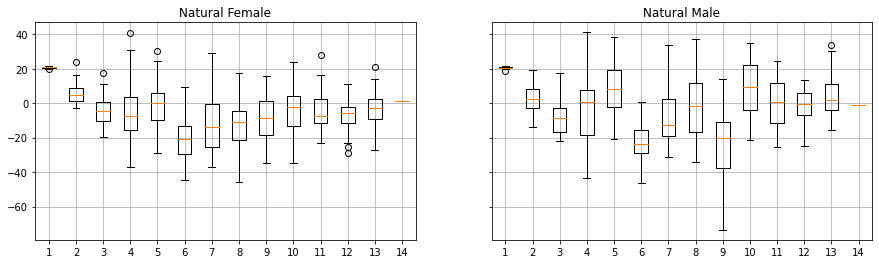

In [6]:
f, (ax1, ax2) = pl.subplots(1,2, sharey='all', figsize=(15,4))
ax1.plot()
ax1.boxplot(naf_mfcc_median)
ax1.set_title('Natural Female')
ax1.grid()
ax2.boxplot(nam_mfcc_median)
ax2.set_title('Natural Male')
ax2.grid()

## Normalisation
On peut voir que nos variables ne sont pas normalisées. Pour améliorer la rapidité de l'entrainement nous allons les amener à la même echelle [0,1]

In [7]:
from sklearn.preprocessing import MinMaxScaler
# Dataset with both classes
df_mfcc = np.append(naf_mfcc_median, nam_mfcc_median, axis=0)

inputs = df_mfcc[:, :13]

# Normalization of the inputs
df_mfcc = np.append(MinMaxScaler().fit_transform(inputs), df_mfcc[:, [13]], axis=1)

df_mfcc = pd.DataFrame(df_mfcc, columns=[*range(1, 14)] + ['class'])

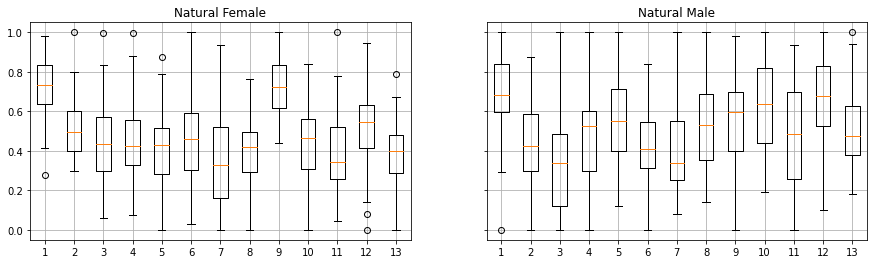

In [8]:
f, (ax1, ax2) = pl.subplots(1,2, sharey='all', figsize=(15,4))
ax1.plot()
ax1.boxplot(df_mfcc.loc[df_mfcc['class'] == 1].loc[:, df_mfcc.columns != 'class'])
ax1.set_title('Natural Female')
ax1.grid()
ax2.boxplot(df_mfcc.loc[df_mfcc['class'] == -1].loc[:, df_mfcc.columns != 'class'])
ax2.set_title('Natural Male')
ax2.grid()

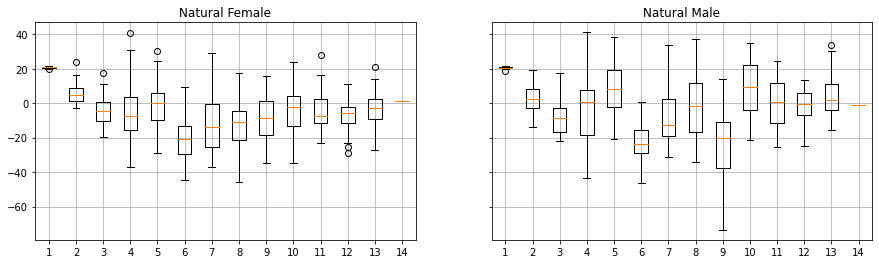

In [9]:
f, (ax1, ax2) = pl.subplots(1,2, sharey='all', figsize=(15,4))
ax1.plot()
ax1.boxplot(naf_mfcc_median)
ax1.set_title('Natural Female')
ax1.grid()
ax2.boxplot(nam_mfcc_median)
ax2.set_title('Natural Male')
ax2.grid()

On a trouvé que les paires de MFCC (8,9), (8,4), (9,4) pourraient être utiles pour la prédiction. Mais pour cette expérience, on peut simplement utiliser l'ensemble complet des MFCC.

# MLP

## Exploring the number of epochs and hyper parameters

Nous faisons un premier entrainement avec des hyper-parametres "standard" pour estimer la complexité du problème

In [10]:
import mlp_backprop_momentum as mlp
import k_fold_cross_validation as cv

# Hyper parameters...
N_INITS = 10
EPOCHS = 200
N_NEURONS = [1, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

In [11]:
MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([13,h,1], 'tanh')
    for i in np.arange(N_INITS):                                        # looping over the initializations
        nn.init_weights()
        MSE[i_h, i, :] = nn.fit((df_mfcc.loc[:, df_mfcc.columns != 'class'], df_mfcc['class']),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


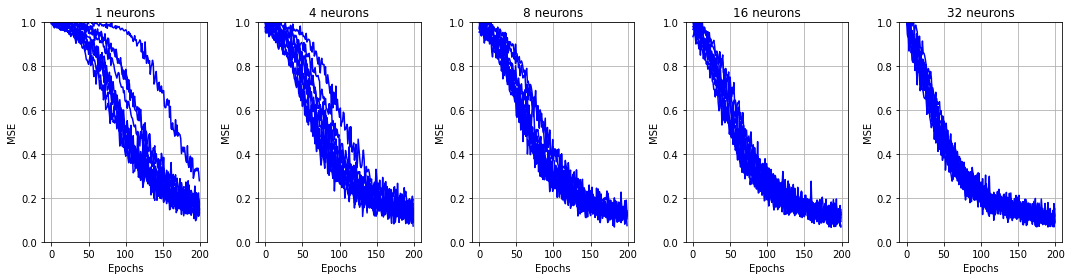

In [12]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

On peut voir que l'erreur ne diminue pas de manière significative après ~150 Epochs peut importe le nombre de neurones dans la couche cachée.
Un learning rate de 0.001 et un momentum de 0.5 donne des résultats qui semblent acceptables. Nous les utiliserons comme base.

## Hyper parameter tuning

In [13]:
def train_model(dataframe, k, n_tests, n_inits, epochs, n_neurons, learning_rate, momentum):
    MSE_train = np.zeros((len(n_neurons), epochs, n_tests))
    MSE_test = np.zeros((len(n_neurons), epochs, n_tests))

    for i_h, h in enumerate(n_neurons):                                     # looping the number of hidden neurons
        print('Testing', h, 'neurons...')
        nn = mlp.MLP([13,h,1], 'tanh')
        for i in np.arange(n_inits):                                        # looping the tests
            nn.init_weights()                                               # the network has to be reinitialized before each test
            temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                                dataframe,    # but cv.k_fold_cross_validation_per_epoch which
                                                                k=k,        # returns a value of error per each epoch
                                                                learning_rate=learning_rate,
                                                                momentum=momentum,
                                                                epochs=epochs)
            # temp1 and temp2 are the training and test error. One value per epoch
            MSE_train[i_h, :, i] = temp1
            MSE_test[i_h, :, i] = temp2
    return MSE_train, MSE_test

In [14]:
def plot_model_perf(MSE_train, MSE_test, n_neurons, filename=None):
    MSE_train_mean = np.mean(MSE_train, axis=2)
    MSE_test_mean = np.mean(MSE_test, axis=2)
    MSE_train_sd = np.std(MSE_train, axis=2)
    MSE_test_sd = np.std(MSE_test, axis=2)

    v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
    v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

    n_rows = int(np.ceil(len(n_neurons)/3.0))
    pl.figure(figsize=(12,3*n_rows))
    for i_n, n in enumerate(n_neurons):
        pl.subplot(n_rows, min(3, len(n_neurons)), i_n+1)
        pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
        pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
        pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
        pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
        pl.ylim(0.95*v_min,0.5*v_max)
        pl.ylabel('MSE')
        pl.xlabel('Number of epochs')
        pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
        pl.legend()
        pl.grid()
    pl.tight_layout()
    if filename is not None:
        pl.savefig('../output/xp1/' + filename + '.png', dpi=500)

Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...


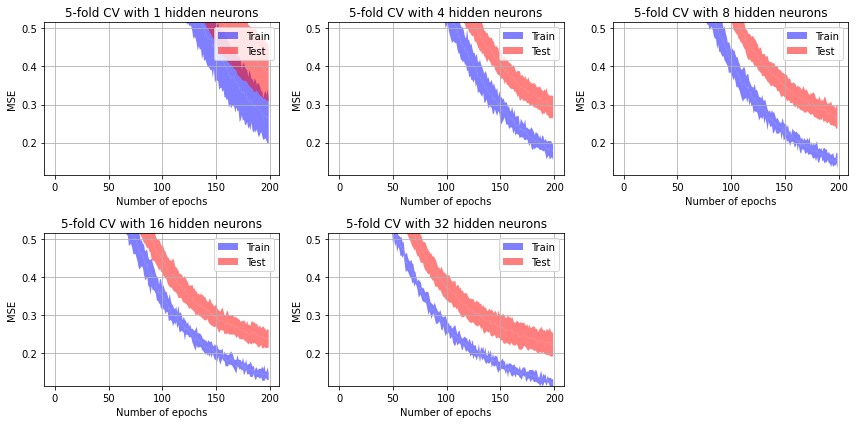

In [15]:
K = 5
N_TESTS = 10

# Hyper parameters...
N_INITS = 10
EPOCHS = 200
N_NEURONS = [1, 4, 8, 16, 32]
LEARNING_RATE = 0.001
MOMENTUM = 0.5

MSE_train, MSE_test = train_model(df_mfcc.to_numpy(), K, N_TESTS, N_INITS, EPOCHS, N_NEURONS, LEARNING_RATE, MOMENTUM)
plot_model_perf(MSE_train, MSE_test, N_NEURONS, 'perf_epoch_' + str(EPOCHS) + '_lr_' + str(LEARNING_RATE) + '_m_'+ str(MOMENTUM))

On essaie un grand ensemble d'hyper paramètre

In [16]:
K = 5
N_TESTS = 10

# Hyper parameters...
N_INITS = 10
EPOCHS = 300
N_NEURONS = [1, 4, 8, 16, 32]
LEARNING_RATE = [0.2, 0.01, 0.0075, 0.005, 0.0025, 0.001, 0.0005]
MOMENTUM = [0.3, 0.4, 0.5, 0.7, 0.8, 0.9]

MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

data = []
cnt = 0
for lr in LEARNING_RATE:
    for mom in MOMENTUM:
        cnt = cnt + 1
        print(cnt, " | learning rate: ", lr , " - momentum: ", mom)
        MSE_train, MSE_test = train_model(df_mfcc.to_numpy(), K, N_TESTS, N_INITS, EPOCHS, N_NEURONS, lr, mom)
        MSE_test_mean = np.mean(MSE_test, axis=2)
        for n_i, n in enumerate(N_NEURONS):
            data.append([lr, mom, n, np.min(MSE_test_mean[n_i])])

1  | learning rate:  0.2  - momentum:  0.3
Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
2  | learning rate:  0.2  - momentum:  0.4
Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
3  | learning rate:  0.2  - momentum:  0.5
Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
4  | learning rate:  0.2  - momentum:  0.7
Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
5  | learning rate:  0.2  - momentum:  0.8
Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
6  | learning rate:  0.2  - momentum:  0.9
Testing 1 neurons...
Testing 4 neurons...
Testing 8 neurons...
Testing 16 neurons...
Testing 32 neurons...
7  | learning rate:  0.01  - momentum:  0.3
Testing 1 neurons...
Testing 4 neurons...
Testing 8 neur

In [17]:
df_data = pd.DataFrame(data, columns=['learning_rate', 'momentum', 'n_neurons', 'min_MSE'])
print(df_data.sort_values('min_MSE'))

     learning_rate  momentum  n_neurons   min_MSE
138         0.0025       0.7         16  0.139832
55          0.0100       0.9          1  0.144593
106         0.0050       0.7          4  0.145081
129         0.0025       0.4         32  0.145855
93          0.0050       0.3         16  0.148233
..             ...       ...        ...       ...
21          0.2000       0.8          4  1.962203
23          0.2000       0.8         16  1.967509
24          0.2000       0.8         32  1.967954
28          0.2000       0.9         16  2.056411
27          0.2000       0.9          8  2.083408

[210 rows x 4 columns]


La paire d'hyper paramètres (learning rate = 0.005, momentum = 0.5) produit le 1er et le 3e meilleur résultat.

momentum            0.3       0.4       0.5       0.7       0.8       0.9
learning_rate                                                            
0.0005         0.343717  0.316743  0.271092  0.198467  0.169379  0.159070
0.0010         0.212720  0.212682  0.191464  0.166381  0.165404  0.155684
0.0025         0.164040  0.145855  0.166065  0.139832  0.148363  0.159959
0.0050         0.148233  0.163894  0.152359  0.145081  0.155616  0.160965
0.0075         0.148710  0.176509  0.165189  0.151452  0.162013  0.168046
0.0100         0.150826  0.158645  0.162868  0.149336  0.150344  0.144593
0.2000         0.184020  0.153881  0.163427  0.562624  1.722333  1.917663


<AxesSubplot:xlabel='momentum', ylabel='learning_rate'>

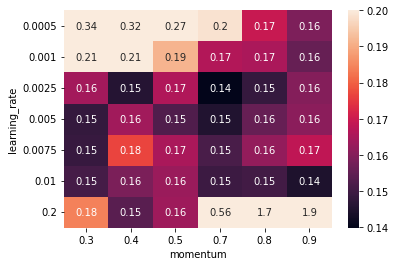

In [32]:
import seaborn as sns

df_wide = df_data.pivot_table( index='learning_rate', columns='momentum', values='min_MSE', aggfunc=min)
sns.heatmap(df_wide, annot=True, vmax=0.2)

In [35]:
best_hyper_params = df_data.sort_values('min_MSE').head()
best_hyper_params

,learning_rate,momentum,n_neurons,min_MSE
138,0.0025,0.7,16,0.139832
55,0.0100,0.9,1,0.144593
106,0.0050,0.7,4,0.145081
129,0.0025,0.4,32,0.145855
93,0.0050,0.3,16,0.148233


Nous allons maintenant tester une par une les combinaisons qui nous ont données les meilleurs résultats. Et voir leur nombre d'epochs optimale

Testing 16 neurons...
Testing 1 neurons...
Testing 4 neurons...
Testing 32 neurons...
Testing 16 neurons...


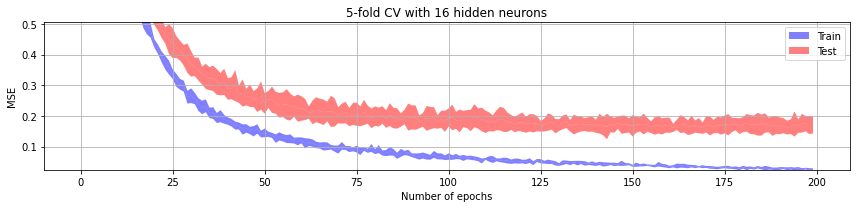

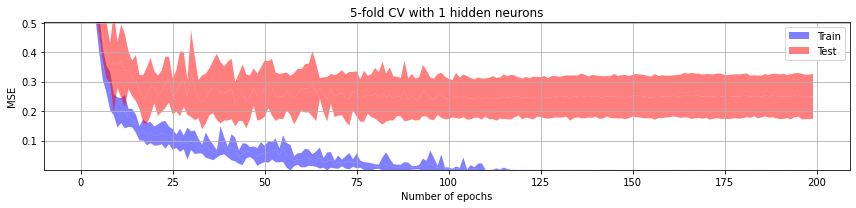

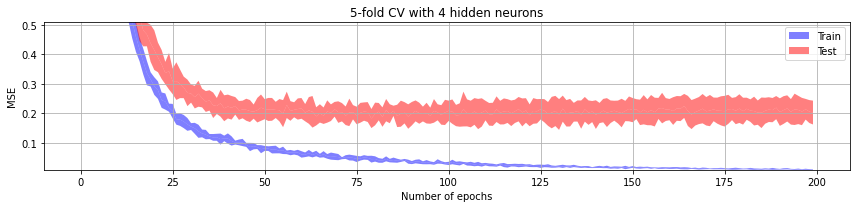

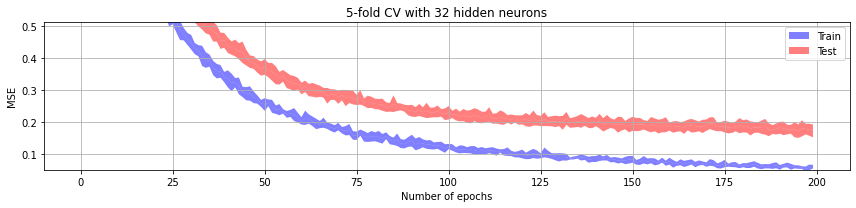

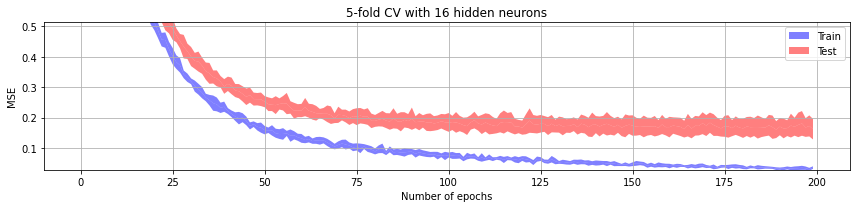

In [40]:
K = 5
N_TESTS = 10
N_INITS = 10
EPOCHS = 200

for index, row in best_hyper_params.iterrows():
    MSE_train, MSE_test = train_model(df_mfcc.to_numpy(), K, N_TESTS, N_INITS, EPOCHS, [int(row['n_neurons'])], row['learning_rate'], row['momentum'])
    plot_model_perf(MSE_train, MSE_test, [int(row['n_neurons'])], 'perf_epoch_' + str(EPOCHS) + '_lr_' + str(row['learning_rate']) + '_m_'+ str(row['momentum']))

A première vue, on peut éliminer la solution à 1 neurone qui à un écart-type énorme comparé aux autres modèles. Nous allons retenir la solution à 4 neurones qui converge plus rapidement, en effet il atteint ses performances optimales après seulement 50 epochs comparé au autres modèles qui le font aux alentours de 125 epochs.



## Final model

Notre modèle final aura donc 4 neurones, 0.005 de learning rate, un momentum de 0.7 et 60 epochs

In [41]:
nn = mlp.MLP([13,4,1], 'tanh')

EPOCHS = 60
LEARNING_RATE = 0.005
MOMENTUM = 0.7

THRESHOLD = 0.0

In [45]:
def k_fold_cross_validation_without_matrix(mlp, dataset, k=5, learning_rate=0.01, momentum=0.7, epochs=100, threshold=None):
    MSE_train_mean = 0.0
    MSE_test_mean = 0.0

    parts = cv.split_dataset(dataset, k)
    #print(parts)
    target_test = []
    output_test = []

    for k_i in np.arange(k):
        mlp.init_weights()

        training_parts = set(np.arange(k))
        training_parts.remove(k_i)
        dataset_train = np.concatenate([parts[i] for i in list(training_parts)])
        dataset_test = parts[k_i]

        input_data = dataset_train[:,0:mlp.n_inputs]
        output_data = dataset_train[:,mlp.n_inputs:(mlp.n_inputs+mlp.n_outputs)]
        input_data_test = dataset_test[:,0:mlp.n_inputs]
        output_data_test = dataset_test[:,mlp.n_inputs:(mlp.n_inputs+mlp.n_outputs)]

        mlp.fit((input_data, output_data),
                learning_rate=learning_rate, momentum=momentum, epochs=epochs)
        MSE_train, _ = mlp.compute_MSE((input_data, output_data))
        MSE_train_mean += MSE_train

        MSE_test, temp_out = mlp.compute_MSE((input_data_test, output_data_test))
        MSE_test_mean += MSE_test
        output_test.append(temp_out)
        target_test.append(output_data_test)

    target_test = np.concatenate(target_test, axis=0)
    output_test = np.concatenate(output_test, axis=0)

    if threshold is None:
        return (MSE_train_mean / k, MSE_test_mean / k)
    else:
        return (MSE_train_mean / k, MSE_test_mean / k, target_test, output_test)

In [46]:
N_SPLITS = 10

MSE_train = np.zeros(N_SPLITS)
MSE_test = np.zeros(N_SPLITS)

targets = []
outputs = []

for d in np.arange(N_SPLITS):
    sys.stdout.write('.')
    temp1, temp2, target, output = k_fold_cross_validation_without_matrix(nn,
                                                              df_mfcc.to_numpy(),
                                                              k=K,
                                                              learning_rate=LEARNING_RATE,
                                                              momentum=MOMENTUM,
                                                              epochs=EPOCHS,
                                                              threshold=THRESHOLD)

    MSE_train[d] = temp1
    MSE_test[d] = temp2
    targets.append(target)
    outputs.append(output)

targets = np.concatenate(targets, axis=0)
outputs = np.concatenate(outputs, axis=0)

..........

In [47]:
conf_mat = cv.compute_confusion_matrix(targets, outputs, THRESHOLD)

y_pred = [-1 if y[0] < THRESHOLD else 1 for y in outputs.tolist()]
y_true = [-1 if y[0] < THRESHOLD else 1 for y in targets.tolist()]

In [48]:
print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  [0.05953992 0.05848116 0.07703437 0.06321359 0.05795499 0.0553638
 0.05743009 0.05977059 0.065605   0.06206153]
MSE test:  [0.1674174  0.3006437  0.27163223 0.30848332 0.17299701 0.19804276
 0.19055596 0.163508   0.17675673 0.17014522]
Confusion matrix:
[[337.  23.]
 [ 34. 326.]]


Calcul des performances...

Accuracy:  0.9208333333333333
F1-Score:  0.9220246238030095
Recall 0.9361111111111111


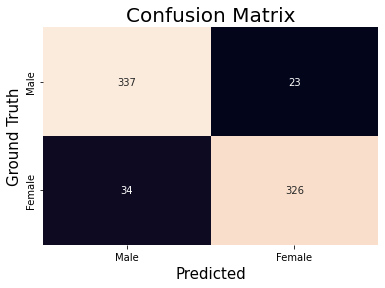

In [49]:
import sklearn.metrics as metrics

# Rows are the actual class and columns are the predicted class
print("Accuracy: ", metrics.accuracy_score(y_true, y_pred))
print("F1-Score: ", metrics.f1_score(y_true, y_pred))
print("Recall", metrics.recall_score(y_true, y_pred))

classes = ['Male', 'Female']
ax = sns.heatmap(conf_mat, annot=True, cbar=False, fmt=".3g", xticklabels=classes, yticklabels=classes)
pl.title('Confusion Matrix', fontsize = 20) # title with fontsize 20
pl.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
pl.ylabel('Ground Truth', fontsize = 15) # y-axis label with fontsize 15

pl.show()

### Exploration d'une solution altérnative potentielle
Nous sommes quand même intéressés par le tuple des hyper-paramètres (learning rate = 0.0025, momentum = 0.4, nombre de neurones = 32) qui semble encore converger à 200 épochs. Nous allons l'entraîner sur une période plus longue pour voir s'il offre des performances significativement meilleures.

Testing 32 neurons...


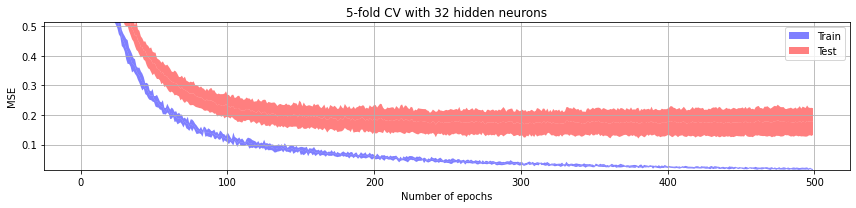

In [50]:
K = 5
N_TESTS = 10

# Hyper parameters...
N_INITS = 10
EPOCHS = 500
N_NEURONS = [32]
LEARNING_RATE = 0.0025
MOMENTUM = 0.4

MSE_train, MSE_test = train_model(df_mfcc.to_numpy(), K, N_TESTS, N_INITS, EPOCHS, N_NEURONS, LEARNING_RATE, MOMENTUM)
plot_model_perf(MSE_train, MSE_test, N_NEURONS, 'perf_epoch_' + str(EPOCHS) + '_lr_' + str(LEARNING_RATE) + '_m_'+ str(MOMENTUM))

..........Accuracy:  0.9361111111111111
F1-Score:  0.9368131868131868
Recall 0.9472222222222222


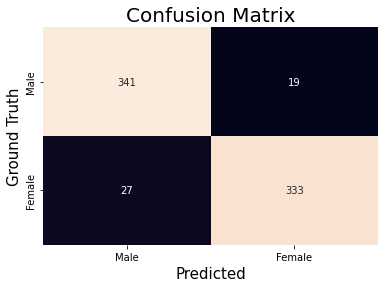

In [51]:
nn = mlp.MLP([13,32,1], 'tanh')

EPOCHS = 500
LEARNING_RATE = 0.0025
MOMENTUM = 0.4

THRESHOLD = 0.0

N_SPLITS = 10

MSE_train = np.zeros(N_SPLITS)
MSE_test = np.zeros(N_SPLITS)

targets = []
outputs = []

for d in np.arange(N_SPLITS):
    sys.stdout.write('.')
    temp1, temp2, target, output = k_fold_cross_validation_without_matrix(nn,
                                                              df_mfcc.to_numpy(),
                                                              k=K,
                                                              learning_rate=LEARNING_RATE,
                                                              momentum=MOMENTUM,
                                                              epochs=EPOCHS,
                                                              threshold=THRESHOLD)

    MSE_train[d] = temp1
    MSE_test[d] = temp2
    targets.append(target)
    outputs.append(output)

targets = np.concatenate(targets, axis=0)
outputs = np.concatenate(outputs, axis=0)

conf_mat = cv.compute_confusion_matrix(targets, outputs, THRESHOLD)

y_pred = [-1 if y[0] < THRESHOLD else 1 for y in outputs.tolist()]
y_true = [-1 if y[0] < THRESHOLD else 1 for y in targets.tolist()]

# Rows are the actual class and columns are the predicted class
print("Accuracy: ", metrics.accuracy_score(y_true, y_pred))
print("F1-Score: ", metrics.f1_score(y_true, y_pred))
print("Recall", metrics.recall_score(y_true, y_pred))

classes = ['Male', 'Female']
ax = sns.heatmap(conf_mat, annot=True, cbar=False, fmt=".3g", xticklabels=classes, yticklabels=classes)
pl.title('Confusion Matrix', fontsize = 20) # title with fontsize 20
pl.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
pl.ylabel('Ground Truth', fontsize = 15) # y-axis label with fontsize 15

pl.show()